# Virtual Running Relay
West End Runners vs Other Clubs 
May 2020

West End Runners in Leicester challenge local clubs to a virtual running relay

During the lock-down, club runners are missing the buzz and companionship of races. But we can still compete virtually!

35 runners per club, 30 minute slots run from anywhere, how far in total can each club go? Most cummulative mileage wins.

This notebook digs into the stats of two recent races:

2 May: West End Runners (WER) vs Wigston Phoenix (WP)  
9 May: West End Runners (WER) vs Wellingborough & District Athletic Club (WDAC)  

Various statistical plots are created, along with a heat map of routes, drawn from gpx files.

Interactive map is available online via GitHub pages: [Virtual Running Relays map](https://tamelamaciel.github.io/virtual_running_relays/)

### Setup

In [54]:
#load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # plotting package, wrapper for matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting package
%matplotlib inline 

In [2]:
data_dir="/Users/Tamela/CODE/src/github.com/tm419/Virtual Running Relays/"

In [22]:
# SET WHICH RELAY DATA TO LOAD HERE:
# OPTIONS:
# West End vs Wigston Phoenix (WP), 2 May: WEvsWP_data/wer_vs_wp_2_may_2020.csv
# West End vs Wellingborough (WDAC), 9 May: WEvsWDAC_data/wer_vs_wdac_9_may_2020.csv
relay_data_name = "WERvsWDAC_data/wer_vs_wdac_9_may_2020.csv"

# SET DATE OF RELAY FOR PLOTTING:
date = "9 May 2020"

# SET CLUB ACRONYMNS FOR NAMING
ateam = 'WER'
bteam = 'WDAC'
#bteam = 'WP'

In [16]:
df = pd.read_csv(data_dir+relay_data_name)

### Data Exploration 

In [5]:
df.head(15)

,west_end_runner,distance_miles,wellingborough_runner,distance_miles.1
0,WE1,3.93,Wel1,4.55
1,WE2,3.49,Wel2,3.64
2,WE3,3.53,Wel3,3.85
3,WE4,5.20,Wel4,4.18
4,WE5,3.56,Wel5,3.03
5,WE6,3.55,Wel6,3.91
6,WE7,4.80,Wel7,2.70
7,WE8,5.04,Wel8,3.48
8,WE9,4.60,Wel9,4.36
9,WE10,4.12,Wel10,3.46


In [6]:
df.dtypes

west_end_runner           object
distance_miles           float64
wellingborough_runner     object
distance_miles.1         float64
dtype: object

In [7]:
df.describe()

,distance_miles,distance_miles.1
count,35.000000,35.000000
mean,4.036571,3.859429
std,0.652732,0.497150
min,3.000000,2.700000
25%,3.510000,3.500000
50%,3.930000,3.820000
75%,4.575000,4.180000
max,5.200000,4.820000


### Data cleaning and feature engineering

In [17]:
#rename columns to avoid duplicates of 'distance_miles', and remove uppercase Time

df=df.rename(columns={"west_end_runner":ateam+"_runner","wellingborough_runner":bteam+"_runner","distance_miles":ateam+"_miles","distance_miles.1":bteam+"_miles"})

In [9]:
#check this renaming worked:

df.describe()

,WER_miles,WDAC_miles
count,35.000000,35.000000
mean,4.036571,3.859429
std,0.652732,0.497150
min,3.000000,2.700000
25%,3.510000,3.500000
50%,3.930000,3.820000
75%,4.575000,4.180000
max,5.200000,4.820000


Using the standard descriptive statistics from pd.describe() above, we can quickly deduce the average mileage per club, as well as the spread between minimum miles and maximum miles per runner, per club. 

However, we'll also plot these stats in a boxplot below for easier visualisation.

In [18]:
#calculate total mileage per club

sum_a = sum(df[ateam+'_miles'])
sum_b = sum(df[bteam+'_miles'])
print(ateam+" total mileage: %.2f miles" % sum_a)
print(bteam+" total mileage: %.2f miles "% sum_b) 
print("Difference between clubs: %.2f miles" % (sum_a-sum_b))

WER total mileage: 141.28 miles
WDAC total mileage: 135.08 miles 
Difference between clubs: 6.20 miles


While it's clear which club won the day, let's analyse this further and see how the running total between the clubs varied over the day.

In [19]:
#create new features (columns): cummulative mileage per club. 

def cummulative_total(runner_miles):
    '''Calculate the cummulative running total of miles per club'''
    global total_mileage
    total_mileage=total_mileage+runner_miles
    return total_mileage

#calculate running total for West End Runners (WER)
total_mileage=0
df[ateam+'_total_miles']=df[ateam+'_miles'].apply(cummulative_total)

#calculate running total for the other club
total_mileage=0
df[bteam+'_total_miles']=df[bteam+'_miles'].apply(cummulative_total)

In [12]:
#check this worked
df.head(10)

,WER_runner,WER_miles,WDAC_runner,WDAC_miles,WER_total_miles,WDAC_total_miles
0,WE1,3.93,Wel1,4.55,3.93,4.55
1,WE2,3.49,Wel2,3.64,7.42,8.19
2,WE3,3.53,Wel3,3.85,10.95,12.04
3,WE4,5.20,Wel4,4.18,16.15,16.22
4,WE5,3.56,Wel5,3.03,19.71,19.25
5,WE6,3.55,Wel6,3.91,23.26,23.16
6,WE7,4.80,Wel7,2.70,28.06,25.86
7,WE8,5.04,Wel8,3.48,33.10,29.34
8,WE9,4.60,Wel9,4.36,37.70,33.70
9,WE10,4.12,Wel10,3.46,41.82,37.16


In [20]:
#create new feature (column) that shows the running total in total mileage difference between the two clubs

df['mileage_difference'] = df[ateam+'_total_miles']-df[bteam+'_total_miles']
df

,WER_runner,WER_miles,WDAC_runner,WDAC_miles,WER_total_miles,WDAC_total_miles,mileage_difference
0,WE1,3.93,Wel1,4.55,3.93,4.55,-0.62
1,WE2,3.49,Wel2,3.64,7.42,8.19,-0.77
2,WE3,3.53,Wel3,3.85,10.95,12.04,-1.09
3,WE4,5.20,Wel4,4.18,16.15,16.22,-0.07
4,WE5,3.56,Wel5,3.03,19.71,19.25,0.46
5,WE6,3.55,Wel6,3.91,23.26,23.16,0.10
6,WE7,4.80,Wel7,2.70,28.06,25.86,2.20
7,WE8,5.04,Wel8,3.48,33.10,29.34,3.76
8,WE9,4.60,Wel9,4.36,37.70,33.70,4.00
9,WE10,4.12,Wel10,3.46,41.82,37.16,4.66


### Data visualisation

This dataset set now shows the running totals and running difference (in miles) between the two clubs throughout the day. It's ready for some data visualisation to better understand the strengths of the clubs.

In [21]:
#make dummy variable column for if West End Runners are ahead. This will be used to colour the bars in the plots below.

df['WER_ahead']=df['mileage_difference']>0
df.head()

,WER_runner,WER_miles,WDAC_runner,WDAC_miles,WER_total_miles,WDAC_total_miles,mileage_difference,WER_ahead
0,WE1,3.93,Wel1,4.55,3.93,4.55,-0.62,False
1,WE2,3.49,Wel2,3.64,7.42,8.19,-0.77,False
2,WE3,3.53,Wel3,3.85,10.95,12.04,-1.09,False
3,WE4,5.20,Wel4,4.18,16.15,16.22,-0.07,False
4,WE5,3.56,Wel5,3.03,19.71,19.25,0.46,True


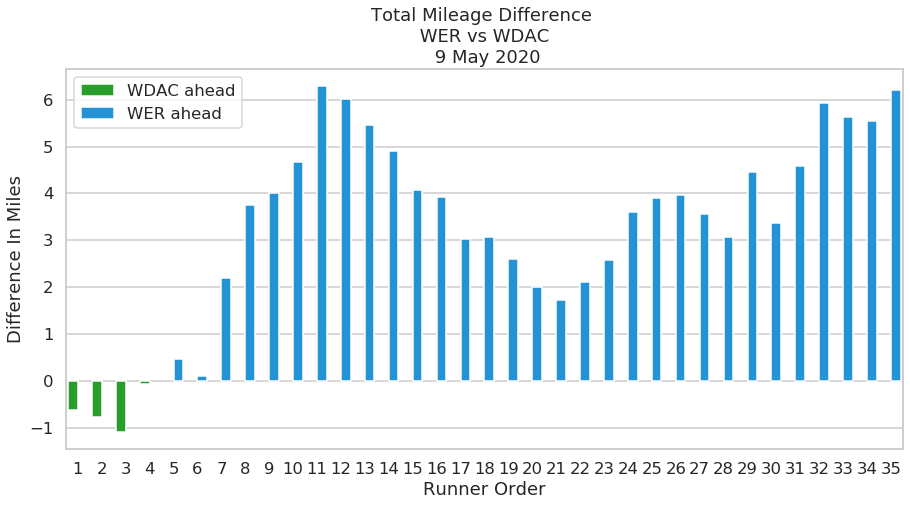

In [64]:
# Make bar chart of how the total mileage difference between the clubs varied throughout the day

plt.figure(figsize=(15,7))

colours={True:sns.xkcd_rgb["azure"],False:sns.xkcd_rgb["green"]} #note color palette draws from xkcd named colours https://xkcd.com/color/rgb/
runnerorder=np.arange(1,36,1,dtype=int).tolist()

sns.set(style="whitegrid")
sns.set_context("talk") #makes labels and text bigger

#set font
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = "Gill Sans MT"

g = sns.barplot(x="WER_runner",y="mileage_difference", data=df, hue="WER_ahead",palette=colours) 

g.set_xticklabels(runnerorder) 

# get legend handles and labels and modify text and location:
current_handles, current_labels = plt.gca().get_legend_handles_labels()
plt.legend(current_handles,["WDAC ahead","WER ahead"],loc='upper left')

plt.title("Total Mileage Difference \n "+ateam+" vs "+bteam+" \n "+date)
plt.ylabel("Difference In Miles")
plt.xlabel("Runner Order")

# save plot
plt.savefig("total_mileage_difference"+ateam+"_"+bteam+".png",dpi=300,bbox_inches='tight') #bbox_inches=tight prevents the image being cutoff during save

plt.show()

From this plot, we can see when West End Runners (blue bars) were ahead throughout the day, and how close the tally was at certain points. The variation throughout the day all depends on the random pairing beteween runners from each club. Each club had fast and slow runners.  
Let's look at the actual distribution of individual mileage with a boxplot.

First we need to reshape the data a bit. We'll create a new dataframe that has one column for miles and one column for club:

In [67]:
#west end club df
df_we=df[['WER_runner','WER_miles']] #create a new dataframe with just club and miles
df_we.columns= ['club','miles'] #rename columns to be more generic
df_we.loc[:,'club']='West End' #assign 'West End' to all values for club

#rival club df
df_bteam=df[[bteam+'_runner',bteam+'_miles']] #create a new dataframe with just club and miles
df_bteam.columns= ['club','miles'] #rename columns to be more generic
if bteam=='WP':
    df_bteam.loc[:,'club']='Wigston Phoenix' 
elif bteam=='WDAC':
    df_bteam.loc[:,'club']='Wellingborough'

#concat the two club dataframes into one
df_merge=pd.concat([df_we,df_bteam], ignore_index=True)

#sort by time
#df_merge.sort_values(by=['time'],ignore_index=True,inplace=True)

df_merge.sample(10)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,club,miles
59,Wellingborough,4.82
57,Wellingborough,3.80
58,Wellingborough,3.52
61,Wellingborough,4.10
24,West End,5.12
9,West End,4.12
49,Wellingborough,4.12
42,Wellingborough,3.48
68,Wellingborough,4.58
8,West End,4.60


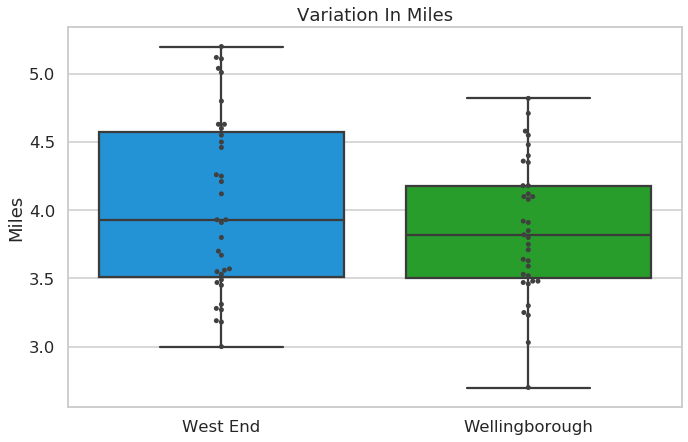

In [72]:
# Draw a boxplot to variation between the two clubs runner mileage
plt.figure(figsize=(11,7))

sns.set(style="whitegrid")
sns.set_context("talk") #makes labels and text bigger

#set font
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = "Gill Sans MT"

if bteam=='WP':
    colours={'West End':sns.xkcd_rgb["azure"],'Wigston Phoenix':sns.xkcd_rgb["green"]}
if bteam=='WDAC':
    colours={'West End':sns.xkcd_rgb["azure"],'Wellingborough':sns.xkcd_rgb["green"]}


ax=sns.boxplot(x="club", y="miles", data=df_merge,palette=colours)
ax=sns.swarmplot(x="club", y="miles", data=df_merge, color=".25")
#sns.despine()

plt.title("Variation In Miles")
plt.ylabel("Miles")
plt.xlabel("")

# save plot
plt.savefig("boxplot_mileage_variation"+ateam+"_"+bteam+".png",dpi=300,bbox_inches='tight') #bbox_inches=tight prevents the image being cutoff during save

plt.show()

With this boxplot, we can quickly determine which club had the higher average mileage per runner, as well as the bigger spread of mileage.  
The overlayed swarmplot allows us to see the distribution of the individual data points.

### Map of routes

As each runner ran by themselves at the set time, we were like ships passing in the night. However, we all live locally and knew that we often ran the same routes (especially the downhill roads!), albiet at different times of the day.

For the second relay race, between West End and Wellingborough, I managed to collect most of the individual routes as gpx files off strava. The total number of routes is printed below.

Let's plot these routes as overlapping paths on the same OpenStreet map, using gpxpy to parse the files and folium for mapping.

NOTE: this mapping will only work for WER vs WDAC, as gpx files were not collected for the first relay race, WER vs WP.

In [73]:
import gpxpy #reading and parsing gps files
import folium #mapping
from folium.plugins import FloatImage #for map legend image

In [74]:
# get list of gps files in directory
import os
ateam_gps_files=[]
bteam_gps_files=[]

for dirname, _, filenames in os.walk(data_dir+ateam+'vs'+bteam+'_data/'+ateam+'_gps/'):
    for filename in filenames:
        if filename[-3:]=='gpx': #only select gpx files
            file=os.path.join(dirname, filename)
            ateam_gps_files.append(file)
for dirname, _, filenames in os.walk(data_dir+ateam+'vs'+bteam+'_data/'+bteam+'_gps/'):
    for filename in filenames:
        if filename[-3:]=='gpx':
            file=os.path.join(dirname, filename)
            bteam_gps_files.append(file)
            
# EDIT THIS TO SUIT RELAY
legend_image="https://raw.githubusercontent.com/tm419/virtual_running_relays/master/legend_"+ateam+"vs"+bteam+".png"

In [75]:
print("Number of "+ateam+" gps routes: "+str(len(ateam_gps_files)))
print("Number of "+bteam+" gps routes: "+str(len(bteam_gps_files)))

Number of WER gps routes: 29
Number of WDAC gps routes: 19


In [76]:
# define a function to read in the gpx file and convert to dataframe
# This code is adapted from datachico's notebook: https://github.com/datachico/gpx_to_folium_maps/blob/master/folium_maps_From_GPX.ipynb

def process_gpx_to_df(file_name):

    gpx = gpxpy.parse(open(file_name))  
    
    #make DataFrame
    track = gpx.tracks[0]
    segment = track.segments[0]
    
    # Load the data into a Pandas dataframe (by way of a list)
    data = []
    
    #segment_length = segment.length_3d()
    for point_idx, point in enumerate(segment.points):
        data.append([point.longitude, point.latitude,point.elevation,
                     point.time, segment.get_speed(point_idx)])
    columns = ['Longitude', 'Latitude', 'Altitude', 'Time', 'Speed']
    gpx_df = pd.DataFrame(data, columns=columns)
    
    # create a tuple of points (lat and long) for line)
    points = []
    for track in gpx.tracks:
        for segment in track.segments:        
            for point in segment.points:
                points.append(tuple([point.latitude, point.longitude]))
    
    return gpx_df, points

In [77]:
# Test of function
gpx_df,points = process_gpx_to_df(ateam_gps_files[0])

In [78]:
#Check the process function worked.
#gpx_df looks like the following:

gpx_df.head()

,Longitude,Latitude,Altitude,Time,Speed
0,-1.19292,52.61404,80.56,None,None
1,-1.19222,52.61396,80.30,None,None
2,-1.19173,52.61386,80.37,None,None
3,-1.19147,52.61382,80.48,None,None
4,-1.19140,52.61380,80.61,None,None


In [79]:
#Check the process function worked.
#points tuple looks like the following:

points[0:10]

[(52.61404, -1.1929200000000002),
 (52.613960000000006, -1.19222),
 (52.61386, -1.1917300000000002),
 (52.613820000000004, -1.19147),
 (52.613800000000005, -1.1914),
 (52.61375, -1.1907800000000002),
 (52.6137, -1.19052),
 (52.61363000000001, -1.19038),
 (52.61366, -1.19032),
 (52.61341, -1.19019)]

In [81]:
# define a function to make the map, and layer the routes as paths on top of base OpenStreet map

def make_folium_map(ateam_gps_files,bteam_gps_files,map_name='map_WER_vs_WDAC.html',plot_method='poly_line',zoom_level=12,map_type='regular',fullscreen=False):
    '''Make map of gps routes'''
    i=0
    #set club colors for routes 
    ateam_color="#28aaf0" #ateam color
    bteam_color="#1e8800" #bteam color. ADJUST IF RIVAL CLUB COLOUR IS DIFFERENT
    
    #first plot map and ateam routes:
    
    #convert to DF and points tuple
    for file_name in ateam_gps_files:

        df, points = process_gpx_to_df(file_name)
        
        #centre map on the lat and long of Leicester city centre
        lat=52.633331 #option: df.Latitude.mean()
        long=-1.133333 #option: df.Longitude.mean()
        
        if i==0:
            #create map layer
            mymap = folium.Map( location=[ lat, long ], zoom_start=zoom_level, tiles=None)
            folium.TileLayer('openstreetmap', name='OpenStreet Map').add_to(mymap)
            #folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}', attr="Tiles &copy; Esri &mdash; National Geographic, Esri, DeLorme, NAVTEQ, UNEP-WCMC, USGS, NASA, ESA, METI, NRCAN, GEBCO, NOAA, iPC", name='Nat Geo Map').add_to(mymap)
        
        #plot ateam tracks
        folium.PolyLine(points,color=ateam_color, weight=4.5, opacity=0.65).add_to(mymap)
        i+=1
        
    #plot bteam tracks
    for file_name in bteam_gps_files:
        
        df, points = process_gpx_to_df(file_name)

        folium.PolyLine(points,color=bteam_color, weight=4.5, opacity=0.65).add_to(mymap)        

    # add legend image to map. Note this image was created manually in powerpoint first.
    FloatImage(legend_image, bottom=10, left=5).add_to(mymap)

    folium.LayerControl(collapsed=True).add_to(mymap)
    mymap.save(map_name)
    return mymap

In [82]:
make_folium_map(ateam_gps_files,bteam_gps_files)

### Conclusion

That's it! Some simple data cleaning, exploration, statistial plots, and mapping, using two datasets near and dear to the hearts of West End Runners in Leicester.

**FUTURE TO DO**

* Make paths interactive by displaying total mileage and elevation change when path is selected.
* Colour paths by total elevation change
* Create side-on elevation plot, with overlapping routes 

Created by Tamela Maciel, May 2020.